# Recreating Fama-French SMB

This post will focus on the equity market. I will describe and then recreate the 10 Fama-French (FF) Small-Minus-Big (SMB) decile portfolios. 

<P>Some basics on SMB. In the early 1980s researchers began to poke holes in CAPM. One early problem with CAPM was the consistently higher returns from small stocks relative to large stocks. Eugene Fama and Ken French formalized this in their 1992 and 1993 papers that debuted their 3-factor model for stock returns (other 2 factors are the market and value). Their model explained a large portion of cross sectional variation in returns. 
<p>
The model has since been updated but was a benchmark of cross sectional asset pricing research for 2 decades. That it was a bench mark was in part due to the data for the portfolios being posted on Ken French’s website (http://bit.ly/1jwasZk). The site provides much useful data for testing asset pricing. 
<p>
Below, I recreate the 10 decile SMB portfolios and then check them versus the return series from the website. The sorting methodology I use extends to other assets or potential return factors. A researcher can sort into portfolios based on a given metric and see if a return spread is generated. From there, one can start running asset pricing tests like Fama-Macbeth regressions, GRS tests or alphas to known factors to identify if they have discovered an interesting phenomena.

#  Importing Packages

We start by just importing packages. I just import anything I might use. 

In [97]:
import pandas as pd
from pandas import *
import pylab as plt
from pylab import *
import numpy as np
import csv as csv
import matplotlib
%matplotlib inline
import scipy
import statsmodels.api as sm
from statsmodels import *
import datetime as dt
from datetime import *
import os
import warnings
warnings.filterwarnings('ignore')


def side_by_side(*objs, **kwds):
    from pandas.core.common import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print adjoin(space, *reprs)

plt.rc('figure', figsize=(10, 6))

# Read CRSP into Memory

First I read the CRSP database into memory. CRSP is provided by the University of Chicago but available on WRDS. It has montly stock returns going back to the 1920s. The dataset is ~ 4mm lines long. The figure below shows the head of my dataset and the datatypes of each columns.

In [98]:
CRSP = pd.read_csv('CRSP Monthly.csv')
print len(CRSP)
CRSP.head()

4149863


,PERMNO,date,SHRCD,EXCHCD,SICCD,DLRET,PRC,VOL,RET,SHROUT,vwretd
0,10000,1985/12/31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043061
1,10000,1986/01/31,10,3,3990,NaN,-4.3750,1771,C,3680,0.009829
2,10000,1986/02/28,10,3,3990,NaN,-3.2500,828,-0.257143,3680,0.072500
3,10000,1986/03/31,10,3,3990,NaN,-4.4375,1078,0.365385,3680,0.053885
4,10000,1986/04/30,10,3,3990,NaN,-4.0000,957,-0.098592,3793,-0.007900


In [99]:
CRSP.dtypes

PERMNO      int64
date       object
SHRCD     float64
EXCHCD    float64
SICCD      object
DLRET      object
PRC       float64
VOL       float64
RET        object
SHROUT    float64
vwretd    float64
dtype: object

# Basic Data Manipulation

Here I shink the dataset so we can operate on it more quickly. 

In [100]:
CRSP['date'] = CRSP.date.str[:4] + '-' + CRSP.date.str[5:7] + '-' + CRSP.date.str[8:10]
CRSP['date'] = to_datetime(CRSP['date'])
CRSP = (CRSP.sort(['date','PERMNO'])).reset_index(drop=True)
print 'Dataset Begins ->', CRSP['date'].min(),'. Dataset Ends ->',CRSP['date'].max()

Dataset Begins -> 1927-01-31 00:00:00 . Dataset Ends -> 2014-12-31 00:00:00


In [101]:
CRSP = CRSP[CRSP['date'] >= datetime(1990,6,1) ]
CRSP = CRSP[CRSP['date'] <= datetime(2014,7,1) ]

CRSP contains stocks that are not common shares. I keep on those with share code 10 and 11 in line with FF. Then I keep only the NYSE, AMEX and NASDAQ stocks. Finally, I convert negative prices (which are indicative of no trade and therefore an estimated price) to positive prices. 

In [102]:
CRSP = CRSP[(CRSP['SHRCD'] == 10) | (CRSP['SHRCD'] == 11)]
CRSP = CRSP[(CRSP['EXCHCD'] == 1) | (CRSP['EXCHCD'] == 2) | (CRSP['EXCHCD'] == 3)]
CRSP = CRSP.drop('SHRCD',1)
len(CRSP)

1582613

In [103]:
CRSP['PRC'] = abs(CRSP['PRC'])
CRSP['MKT_CAP'] = abs(CRSP['PRC'] * CRSP['SHROUT'])

Next I focus on returns. I convert all non-float data to null values and then convert to floats.

I do this for delisting returns (which are the returns of a stock before it gets delisted) and other stock returns.  

In [104]:
CRSP.RET[CRSP['RET'] == 'C'] = np.nan
CRSP.RET[CRSP['RET'] == 'B'] = np.nan
CRSP.RET = CRSP.RET.astype(float)

CRSP.DLRET[CRSP['DLRET'] == 'A'] = np.nan
CRSP.DLRET[CRSP['DLRET'] == 'S'] = np.nan
CRSP.DLRET[CRSP['DLRET'] == 'T'] = np.nan
CRSP.DLRET[CRSP['DLRET'] == 'P'] = np.nan
CRSP.DLRET = CRSP.DLRET.astype(float)
CRSP.dtypes

PERMNO              int64
date       datetime64[ns]
EXCHCD            float64
SICCD              object
DLRET             float64
PRC               float64
VOL               float64
RET               float64
SHROUT            float64
vwretd            float64
MKT_CAP           float64
dtype: object

Next I add delisting returns to actual returns. 

In [105]:
CRSP.RET[isnull(CRSP['DLRET'])] = CRSP.RET
CRSP.RET[(notnull(CRSP['DLRET'])) & (isnull(CRSP['RET'])) ] = CRSP.DLRET
CRSP.RET[(notnull(CRSP['DLRET'])) & (notnull(CRSP['RET'])) ] = CRSP.DLRET + CRSP.RET
CRSP.drop('DLRET', axis=1, inplace=True)

Later FF will use months in their portfolio construction. I create columns for month and year that we can use for this later. 

In [106]:
CRSP['year'] = CRSP['date'].dt.year
CRSP['month'] = CRSP['date'].dt.month

FF use an interesting methodology. From French's website "The portfolios for July of year t to June of t+1 include all NYSE, AMEX, and NASDAQ stocks for which we have market equity data for June of t." So the return year will be from June to July. I create a column called portoflio year that will allow us to track a portfolio from July of year t to June of t+1. 

In [107]:
CRSP['portfolio_year'] = CRSP.year - 1
CRSP.portfolio_year[(CRSP.month >= 7) & (CRSP.month <= 12)] = CRSP.year

# Breakpoints

Fama and French use NYSE breakpoints. FF divide up the NYSE in deciles by market cap on each day in the data. Then, based on those NYSE market cap deciles, they allocate stocks from the other exchanges. 
<p>
To calulate breakpoints below, I first take stocks 1) from the month of June, 2) that are in the NYSE and 3) that have a market cap. Poor data would cause a stock to not have a market cap. Second, calculate rank based on market cap for each year in my dataset. Then I assign them to deciles based on that rank. 

In [108]:
CRSP_NYSE_JUNE =  CRSP[CRSP['month'] == 6 ]
CRSP_NYSE_JUNE =  CRSP_NYSE_JUNE[CRSP_NYSE_JUNE['EXCHCD'] == 1 ]
CRSP_NYSE_JUNE =  CRSP_NYSE_JUNE[notnull(CRSP_NYSE_JUNE['MKT_CAP'])]

In [109]:
CRSP_NYSE_JUNE['RANK'] = CRSP_NYSE_JUNE.groupby(['year'])['MKT_CAP'].rank(pct = True)
CRSP_NYSE_JUNE['NYSE_DECILE'] = np.nan
for i in range(1,10):
    CRSP_NYSE_JUNE.NYSE_DECILE[CRSP_NYSE_JUNE.RANK >= float(i)/10] = int(i)+1
CRSP_NYSE_JUNE.NYSE_DECILE[isnull(CRSP_NYSE_JUNE.NYSE_DECILE)] = 1

To create the breakpoint dataset for each year, I find the highest market cap in a given decile for each year. Note taht we can it by year because we limited the dataset to June above. 

In [110]:
BREAKPOINTS = DataFrame(CRSP_NYSE_JUNE.groupby(['year','NYSE_DECILE'])['MKT_CAP'].max())
BREAKPOINTS = BREAKPOINTS.unstack('NYSE_DECILE')
BREAKPOINTS = BREAKPOINTS.reset_index(drop=False)
BREAKPOINTS.columns = BREAKPOINTS.columns.droplevel()
BREAKPOINTS.rename(columns={'': 'year'}, inplace=True)

for i in range(1,11):
    BREAKPOINTS.rename(columns={i: 'NYSE_D_'+str(i)}, inplace=True)
BREAKPOINTS.head()

NYSE_DECILE,year,NYSE_D_1,NYSE_D_2,NYSE_D_3,NYSE_D_4,NYSE_D_5,NYSE_D_6,NYSE_D_7,NYSE_D_8,NYSE_D_9,NYSE_D_10
0,1990,44045.375,95912.250,179984.875,297156.25,493159.50,800212.500,1276420.500,2242767.50,4507827.000,67527250.000
1,1991,39516.750,89855.000,177730.000,289021.25,475664.00,771547.125,1255014.000,2192245.00,4643235.750,72350861.250
2,1992,49079.750,107457.000,191521.000,322165.25,509066.50,843757.250,1308104.000,2472483.75,4917043.500,76848750.000
3,1993,59636.250,141520.875,252222.250,405725.25,622825.50,998024.625,1532247.750,2791733.25,5244044.625,84682017.000
4,1994,63430.000,149435.000,244229.625,389200.00,605422.75,902632.500,1435830.375,2542728.00,5200334.000,79746793.875


Now assign non-NYSE stocks to their portfoios based on their market cap in June. Create a dataset that is every stock in June and merge it with your breakpoints. First merge the breakpoints based on year. 

In [111]:
CRSP_JUNE =  CRSP[CRSP['month'] == 6 ]
CRSP_JUNE['DECILE'] = np.nan
CRSP_JUNE = merge(CRSP_JUNE,BREAKPOINTS,on=['year'], how='outer')

Then assign each stock a Decile. This will be its decile throughout the year. Note that we merge based on portfolio year.

In [112]:
for i in range(1,10):
    CRSP_JUNE.DECILE[CRSP_JUNE.MKT_CAP > CRSP_JUNE['NYSE_D_'+str(i)]] = int(i)+1
CRSP_JUNE.DECILE[isnull(CRSP_JUNE.DECILE)] = 1

In [113]:
CRSP_JUNE = CRSP_JUNE[['PERMNO','year','DECILE']]
CRSP_JUNE.rename(columns={'year': 'portfolio_year'}, inplace=True)

And we're done. Each stock is now assigned to the correct portfolio based on its market cap. 

In [114]:
CRSP = merge(CRSP,CRSP_JUNE,on=['PERMNO','portfolio_year'], how='outer')
CRSP.head()

,PERMNO,date,EXCHCD,SICCD,PRC,VOL,RET,SHROUT,vwretd,MKT_CAP,year,month,portfolio_year,DECILE
0,10001,1990-06-29,3,4920,9.75000,105,0.014103,1031,-0.004196,10052.25000,1990,6,1989,NaN
1,10002,1990-06-29,3,6710,6.37500,69,0.000000,1175,-0.004196,7490.62500,1990,6,1989,NaN
2,10003,1990-06-29,3,6020,5.75000,973,-0.178571,2194,-0.004196,12615.50000,1990,6,1989,NaN
3,10005,1990-06-29,3,1310,0.04688,0,0.000000,8376,-0.004196,392.66688,1990,6,1989,NaN
4,10007,1990-06-29,3,7370,1.96875,6104,-0.100000,4134,-0.004196,8138.81250,1990,6,1989,NaN


Delete bad datapoints.

In [115]:
CRSP = CRSP[notnull(CRSP['date'])]
CRSP = CRSP[notnull(CRSP['DECILE'])]
CRSP = CRSP[notnull(CRSP['MKT_CAP'])]
CRSP.RET[isnull(CRSP.RET)] = 0
CRSP = CRSP.sort(['PERMNO','date'])

# Portfolio Returns

Now that we have the portfolio groupings, we can calculate the equal weighted returns for each portfolio. Generally value weighted returns are more useful in asset pricing (because equal weighted returns bias our portfolio towards small stocks) and they will be calculated below. 

In [116]:
MONTHLY_EW = CRSP.groupby(['date','DECILE'])['RET'].mean()
MONTHLY_EW = MONTHLY_EW.unstack('DECILE')
MONTHLY_EW = MONTHLY_EW.reset_index(drop=False)
MONTHLY_EW.head()

DECILE,date,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
0,1990-07-31,-0.026516,-0.049684,-0.040861,-0.043285,-0.036511,-0.038958,-0.019492,-0.024468,-0.023132,-0.005740
1,1990-08-31,-0.107862,-0.138956,-0.134520,-0.130707,-0.127632,-0.114753,-0.105979,-0.104557,-0.096465,-0.089001
2,1990-09-28,-0.075107,-0.099465,-0.094494,-0.102092,-0.104577,-0.083148,-0.066684,-0.080090,-0.071835,-0.052197
3,1990-10-31,-0.068468,-0.066656,-0.060363,-0.058043,-0.067521,-0.039934,-0.033579,-0.036507,-0.025597,-0.004638
4,1990-11-30,0.003677,0.044639,0.080355,0.086697,0.108824,0.094805,0.094901,0.112393,0.113106,0.068144


Let's check our data vs. French's website. First, I'll import it and slice it such that the dates of French's site line up with the data I created above. 

In [117]:
FFSMB2 = pd.read_csv('SMB 10 Port.csv')
FFSMB = FFSMB2.ix[768:1055,11:22]
print 'Checking to make sure datasets are the same size ->',len(FFSMB) - len(MONTHLY_EW)

FFSMB.head()

Checking to make sure datasets are the same size -> 0


,date.1,EW_10,EW_20,EW_30,EW_40,EW_50,EW_60,EW_70,EW_80,EW_90,EW_100
768,199007,-0.0274,-0.0470,-0.0404,-0.0415,-0.0381,-0.0385,-0.0162,-0.0248,-0.0212,-0.0067
769,199008,-0.1094,-0.1399,-0.1334,-0.1275,-0.1274,-0.1183,-0.1019,-0.1036,-0.0972,-0.0890
770,199009,-0.0756,-0.0990,-0.0942,-0.1013,-0.1032,-0.0820,-0.0643,-0.0841,-0.0678,-0.0526
771,199010,-0.0701,-0.0629,-0.0606,-0.0570,-0.0681,-0.0426,-0.0318,-0.0338,-0.0308,-0.0028
772,199011,0.0049,0.0437,0.0783,0.0861,0.1059,0.0984,0.0900,0.1101,0.1150,0.0682


The loop below checks how closely the match. The columns are:
1. Correlation between i'th portfolio's return and the return from the FF website. 
2. Mean return of the portfolio. 
3. Mean return of the portfolio from French's website. 

<p>
The mean return from the smallest portfolio is too high but the correlations are extremely high. 

In [118]:
print '  Correlation   ','Mean','          Mean of FF'
for i in range (1,11):
    print i, (np.corrcoef(MONTHLY_EW[i],FFSMB['EW_'+str(i*10)]))[1,0], 12* np.mean(MONTHLY_EW[i]), 12* np.mean((FFSMB['EW_'+str(i*10)]))

  Correlation    Mean           Mean of FF
1 0.999566596785 0.184598813959 0.167741666667
2 0.998846100574 0.127733404065 0.1267125
3 0.998364836512 0.133684054603 0.134754166667
4 0.998555525724 0.128616154443 0.123816666667
5 0.997835477364 0.132702639088 0.1329375
6 0.997966734955 0.133843373056 0.13845
7 0.997030605968 0.139342091172 0.136283333333
8 0.997828445135 0.122563255404 0.1243875
9 0.99885192014 0.126535971919 0.125395833333
10 0.999545116003 0.103385051222 0.105141666667


The chart below shows the datasets moving together. 

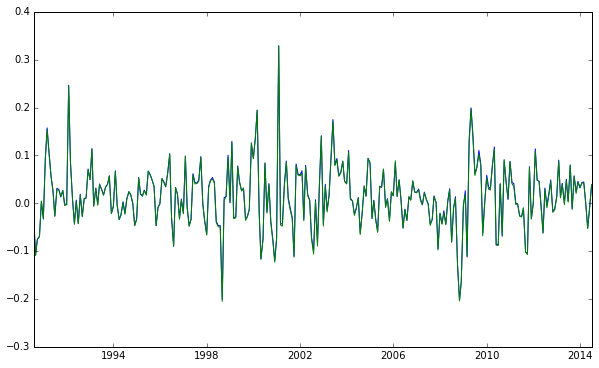

In [119]:
plt.plot(MONTHLY_EW['date'],MONTHLY_EW[1])
plt.plot(MONTHLY_EW['date'],FFSMB['EW_10'])

Now I show the value weighted returns. First I calculate the total market cap in each decile and then divide the market cap of each stock by it. 

In [120]:
WEIGHT = DataFrame(CRSP.groupby(['date','DECILE'])['MKT_CAP'].sum()).reset_index(drop=False)
WEIGHT = WEIGHT.rename(columns={'MKT_CAP':'TOTAL_MKT_CAP'})
CRSP = merge(CRSP,WEIGHT,on=['date','DECILE'], how='inner')
CRSP['WEIGHT'] = CRSP['MKT_CAP'] / CRSP['TOTAL_MKT_CAP']

In [121]:
CRSP = (CRSP.sort(['PERMNO','date'])).reset_index(drop=True)
CRSP['VW_RET'] = CRSP['RET'] * CRSP['WEIGHT'].shift()  #use shift to get last periods value weight
CRSP.VW_RET[CRSP.PERMNO != CRSP.PERMNO.shift()] = np.nan
MONTHLY_VW = CRSP.groupby(['date','DECILE'])['VW_RET'].sum()
MONTHLY_VW = MONTHLY_VW.unstack('DECILE')
MONTHLY_VW = MONTHLY_VW.reset_index(drop=False)
MONTHLY_VW = MONTHLY_VW.ix[1:,:]
MONTHLY_VW.head()

DECILE,date,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
1,1990-08-31,-0.122496,-0.137856,-0.132280,-0.128708,-0.125367,-0.111318,-0.100984,-0.102078,-0.093154,-0.085146
2,1990-09-28,-0.084969,-0.095266,-0.088265,-0.092204,-0.096865,-0.073836,-0.061033,-0.076346,-0.064947,-0.040308
3,1990-10-31,-0.069505,-0.068426,-0.058894,-0.056602,-0.059119,-0.035776,-0.031598,-0.031873,-0.018185,0.004541
4,1990-11-30,0.012750,0.040337,0.069238,0.079965,0.094304,0.086550,0.084103,0.095924,0.094806,0.056317
5,1990-12-31,-0.015409,0.012419,0.034022,0.051225,0.050637,0.048084,0.047256,0.036259,0.037077,0.025331


Again, let's check the value weighted returns vs. French's website. I get even closer here than equal weighted. This is driven by the errors likely coming from smaller stocks. As those receive less weight in the value weighted returns. 

In [123]:
FFSMB = FFSMB2.ix[769:1055,:11]
FFSMB.head()

,date,VW_10,VW_20,VW_30,VW_40,VW_50,VW_60,VW_70,VW_80,VW_90,VW_100
769,199008,-0.1248,-0.1386,-0.1322,-0.1256,-0.1254,-0.1151,-0.1000,-0.1022,-0.0935,-0.0851
770,199009,-0.0860,-0.0941,-0.0881,-0.0925,-0.0951,-0.0724,-0.0584,-0.0804,-0.0628,-0.0404
771,199010,-0.0699,-0.0625,-0.0593,-0.0568,-0.0574,-0.0377,-0.0301,-0.0301,-0.0228,0.0052
772,199011,0.0164,0.0421,0.0676,0.0788,0.0917,0.0896,0.0799,0.0958,0.0969,0.0564
773,199012,-0.0117,0.0144,0.0321,0.0536,0.0453,0.0499,0.0447,0.0383,0.0403,0.0239


In [124]:
print '  Correlation   ','Mean','          Mean of FF'
for i in range(1,11):
    print i, (np.corrcoef(MONTHLY_VW[i],FFSMB['VW_'+str(i*10)]))[1,0], 12*np.mean(MONTHLY_VW[i]), 12*np.mean((FFSMB['VW_'+str(i*10)]))


  Correlation    Mean           Mean of FF
1 0.996830037938 0.140816612871 0.141524738676
2 0.996702606086 0.131596939943 0.135420209059
3 0.997077072811 0.135095824999 0.137857839721
4 0.995261729068 0.129084596853 0.124498954704
5 0.996468025987 0.132458029411 0.1350271777
6 0.996656098909 0.125579609957 0.134859930314
7 0.994176009119 0.136435007752 0.13496445993
8 0.994413525673 0.122661015595 0.128583972125
9 0.995490572964 0.126908621634 0.126029268293
10 0.996267599057 0.0978781967109 0.0994118466899


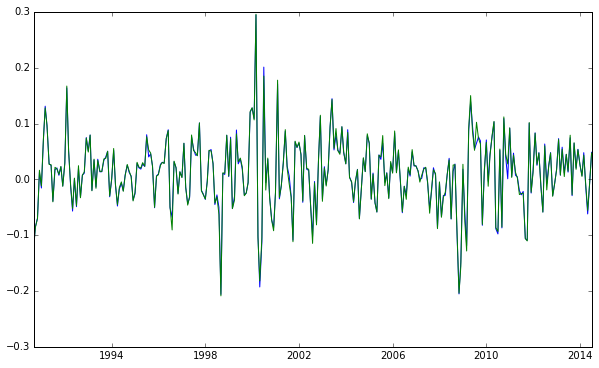

In [125]:
plt.plot(MONTHLY_VW['date'],MONTHLY_VW[1])
plt.plot(MONTHLY_VW['date'],FFSMB['VW_10'])

